In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from __future__ import division, print_function
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from scipy import signal, stats
import h5py
import glob
import pmefm
from collections import OrderedDict
from kpfm.util import h5filename
from kpfm.util import kpfm_data
from kpfm import lockin
from kpfm import util
reload(util)
reload(lockin)

import mpl_toolkits.mplot3d as a3
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

ks = 14950.0

@h5filename
def _h5toPMEFM(f):
    """On 2017-02-17, the modulation circuit had a gain of 0.2."""
    phi_t = f['CPD'][:]
    fs = f.attrs['Inputs.Scan rate [Hz]']
    dt = 1/fs
    T = phi_t.size * dt
    fx = f.attrs['Inputs.Pos Mod Freq (Hz)']
    # Note the factor of 0.2
    x_m = f.attrs['Inputs.Pos Mod rms (V)'] * np.sqrt(2) * 0.2 * 15 * 0.125 
    x_tot = (f.attrs['Inputs.End scan [V]'] -
             f.attrs['Inputs.Start scan [V]']) * 0.125
    v_tip = x_tot / T

    return {'fs': fs, 'fx': fx, 'v_tip': v_tip, 'x_m': x_m, 'phi_t': phi_t}

In [2]:
fname = "../data/KPFM-linescans/170217-1628DPh-BTBT-20V-50-nm-mod-x.h5"
fh = h5py.File(fname)
d = _h5toPMEFM(fh)

In [3]:
fir2 = lockin.lock2(1e3, 1.1, 4.4, d['fs']/d['v_tip'])
CPD = signal.fftconvolve(fh['CPD'][:], fir2, 'valid')

Response:
f   mag       dB
   0.000 1.000    0.000
   0.550 0.983   -0.151
   1.100 0.927   -0.656
   4.400 0.095  -20.488
   8.800 0.000 -101.830
 500.000 0.000 -270.187
1000.000 0.000 -270.321
11037.642 0.000 -345.562


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0855476269131
            Iterations: 6
            Function evaluations: 27
            Gradient evaluations: 6


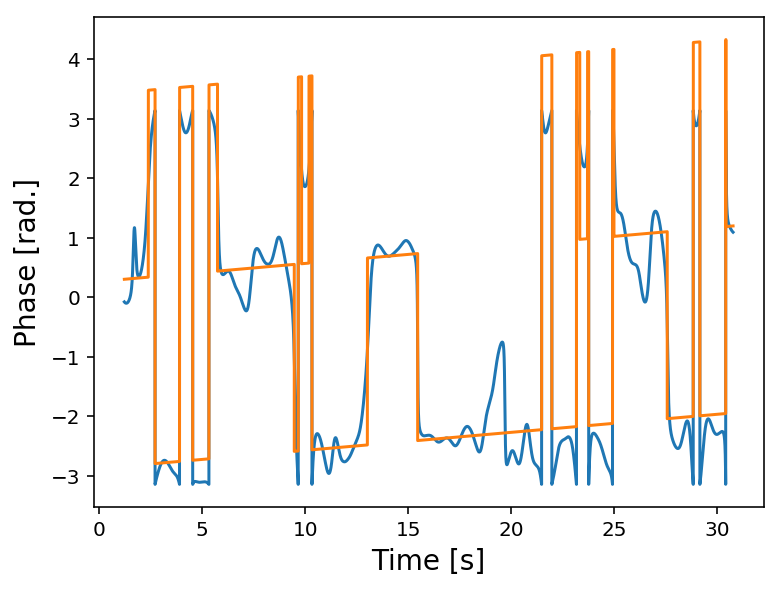

In [4]:
p50 = pmefm.PMEFMEx(**d)
p50.fir_filter(fir_ac=fir2, fir_dc=fir2)
p50.auto_phase()
p50.plot_phase()
p50.output()

In [5]:
m = kpfm_data("../data/KPFM/Feb 17 15-54  image 1.txt")

In [6]:
ys = np.arange(11)
ys = np.array([0.2,0.2, 11.0, 11.0])
zs =np.array( [0, 1, 1, 0])
zs2 = np.zeros_like(ys)

In [7]:
def normalize(x, n=2):
    return x / sum(abs(x)**n)**(1.0/n)

In [8]:
Ex = p50('E_dc')[10000::20000][:-1]
Ey = -p50('E_mod')[10000::20000][:-1]
scan_dir = p50('x')[10000::20000][:-1]

In [9]:
# all_vec_data = [(scan_dir[i], Ex[i], Ey[i]) for i in [0, 1, 2, 4, 5, 6, 8, 9, 10]]

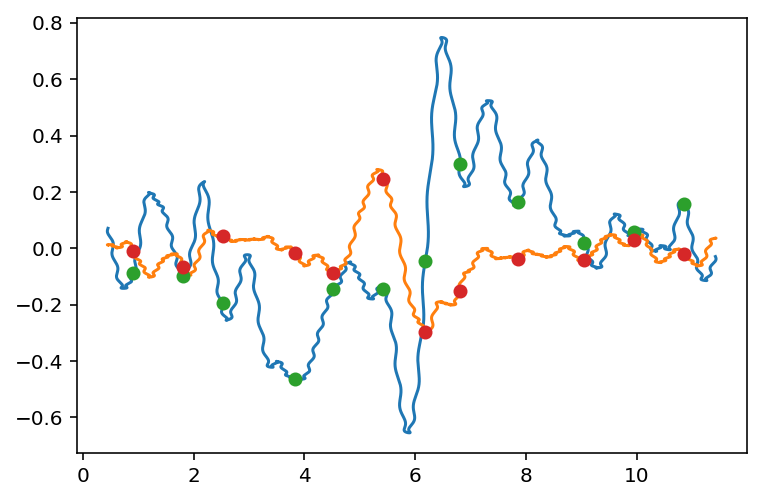

In [10]:
ii = np.array([ 10000,  30000,  45000, 75000, 90000, 110000, 126500, 140000,
       164000, 190000, 210000, 230000])

plt.plot(p50('x'), p50('E_dc'))
plt.plot(p50('x'), p50("E_mod"))
plt.plot(p50('x')[ii], p50('E_dc')[ii], 'o')
plt.plot(p50('x')[ii], p50("E_mod")[ii], 'o')

In [11]:
# Ex = p50('E_dc')[::1500]
# Ey = p50("E_mod")[::1500]
# scan_dir = p50('x')[::1500]
# phi_line = p50('phi')[::1500]

In [12]:
total_change = np.cumsum(abs(np.gradient(p50('E_dc') + 1j *p50("E_mod"))))
total_change = 0.35*total_change / total_change[-1] + 0.65*np.arange(total_change.size)/total_change.size

In [13]:
pts = np.linspace(0, 1, 81)[:-1]
locs = np.array([np.argmax(total_change >= pt) for pt in pts])

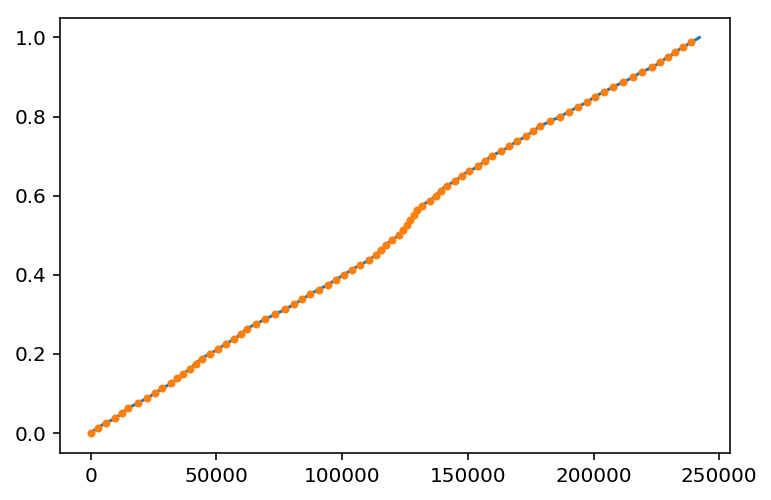

In [14]:
plt.plot(total_change)
plt.plot(locs, total_change[locs], '.')
# plt.axhline(np.mean(abs(np.gradient(p50('E_dc') + 1j *p50("E_mod")))))

In [15]:
# cut = [10, 15, 16, 18, 21, 24, 25,
#        27, 37, 43, 56, 58,60, 61, 63, 64, 66, 68, 69, 72, 73, 74, 86, 
#        90, 92]
cut = np.r_[np.arange(27), [46, 48, 54, 55, 56,57]]
mask = np.ones(locs.size, dtype=bool)
for i in xrange(locs.size):
    if i in cut:
        mask[i] = False

In [16]:
Ex = p50('E_dc')[locs][mask]
Ey = -p50("E_mod")[locs][mask]
scan_dir = p50('x')[locs][mask]
phi_line = p50('phi')[locs][mask]
indices = np.arange(locs.size)[mask]
final_colors = (indices*0.125)%1
adjust_colors = {52: 0, 53: 1}
adjust_z = {20: 10, 21:100, 22:102, 23:101}
zorder = 100 - np.arange(locs.size)[mask]
for (key, val) in adjust_colors.items():
    i = np.argmax(np.arange(locs.size)[mask] == key)
    final_colors[i] = val
    
# for (key, val) in adjust_z.items():
#     i = np.argmax(np.arange(locs.size)[mask] == key)
#     zorder[i] = val
    
    
phi_line = phi_line - phi_line.min()
phi_line = phi_line / phi_line.max()
phi_line = 1 - phi_line

In [17]:
def color2gray(x):
    if len(x) == 3:
        r, g, b = x
        a = 1
    elif len(x) == 4:
        r, g, b, a = x
    else:
        raise ValueError("Incorrect tuple length")
    return (r * 0.299 + 0.587*g + 0.114*b) * a



In [18]:
gray_colors = []
for color in mpl.cm.Greens(np.arange(21)/21):
    gray_colors.append(color2gray(color))

In [19]:
offset_colors = []
for color in gray_colors:
    if color > 0.5:
        offset_colors.append(color-0.3)
    else:
        offset_colors.append(color+0.3)

In [20]:
ind = np.linspace(0, 0.99, 21)

In [21]:
acceptable_shades = OrderedDict((key, color2gray(item)*0.8) for key, item in 
                                zip(np.linspace(0, 0.99, 21), 
                                    mpl.cm.Blues_r(np.linspace(0, 0.99, 21))))

In [22]:
reversed_shades = OrderedDict((val, key) for key, val in acceptable_shades.items())

In [23]:
grayscale_blues = np.array(acceptable_shades.values())

In [24]:
blue_choices = {0:0, 1:7, 2: 14, 3:20}

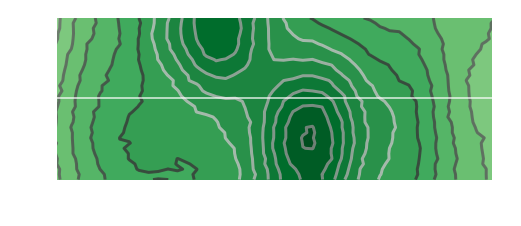

In [27]:
plt.rc('font', size=9)

x = m.vx * 0.125
y = m.vy * 0.125
mx, my = np.meshgrid(x -x.min(), y-y.min()+0.5)

real_contours = np.linspace(-0.2, 1.3, 21)



w=4
ymax = mx[:, :32].max()
xmax = 4

kpfm_phi = m.ch1[i, :]
green_levels = np.linspace(-0.2, 1.3, 21)

fig, ax = plt.subplots(figsize=(3.9, 3.9*ymax/xmax))
contours = ax.contourf(my[:, :32], mx[:, :32], m.ch1[:32, :].T, np.linspace(-0.2, 1.3, 21),
                       cmap=mpl.cm.Greens, alpha=1)
ax.contour(my[:, :32], mx[:, :32], m.ch1[:32, :].T,  real_contours,
           colors=["{:.2f}".format(c) for c  in offset_colors], alpha=0.8, linewidth=0.4)
ax.set_axis_off()
ax.set_ylim(0, ymax)
ax.set_xlim(4, 8)

i = 11
linscan_loc = np.mean(my[:, i]*0.125)
potential = m.ch1[i]
potential_color = ((potential - m.ch1.min())/(m.ch1.max() - potential.min()))
ax.axhline(linscan_loc, color='1.0', alpha=0.8, linewidth=0.8)

scale = 1.4

c_prev = -1

gray_distance = 0.21

# for i, (j, scan_dir_val, ex, ey, z, phi_color) in enumerate(zip(final_colors, scan_dir, Ex, Ey, zorder, phi_line)):
#     i_guess = blue_choices[(i % 4)]
#     c_guess = grayscale_blues[i_guess]
#     kpfm_phi_val = kpfm_phi[int(scan_dir_val / my.max() * 128)]
#     c_compare = color2gray(mpl.cm.Greens(np.argmax(green_levels > kpfm_phi_val) / green_levels.size))
#     if (c_guess - c_compare) < gray_distance or (c_guess - c_prev) < gray_distance:
#         gray_mask = ((abs(grayscale_blues - c_prev) < gray_distance) |
#                     (abs(grayscale_blues - c_compare) < gray_distance))
#         print(min(abs(np.arange(grayscale_blues.size) - i_guess) + gray_mask * 100))
#         i_guess = np.argmin(abs(np.arange(grayscale_blues.size) - i_guess) + gray_mask * 100)

#     color = mpl.cm.Blues_r(ind[i_guess])
#     ax.arrow(scan_dir_val, linscan_loc, ex*scale, ey*scale,
#              head_width=0.05, alpha=0.8, 
#              length_includes_head=False, overhang=0.1,
#              fc='none',
#              linewidth=1.5,
#              ec=color,
#              color=color,
#              zorder=z)
#     print(grayscale_blues[i_guess])
#     c_prev = grayscale_blues[i_guess]

In [28]:
# fig.savefig('../figs/03c-linescan-vector.pdf', bbox_inches='tight')

In [29]:
# !open ../figs/03c-linescan-vector.pdf